# 任務: 爬取停車場地段號、坪數、地主、停車價格。

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1. 爬取停車場地址及停車費 (以臺北市為例)
##### 車麻吉上之資訊來源為app後端資料庫，並非網路上公開之資料，一般人沒有權限用程式爬取，
##### 故先使用臺北市停車管理工程處網站之臺北市公有路外停車場資料。

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://pma.gov.taipei/News.aspx?n=6833ECE829BE5990&sms=504AB58CAE8A1C62&page=1&PageSize=200'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

districts_html = soup.find_all('td', {'data-title': '行政區'})
addresses_html = soup.find_all('td', {'data-title': '停車場地址'})
fees_html = soup.find_all('td', {'data-title': '費率'})

districts = [district.text for district in districts_html]
addresses = [address.text for address in addresses_html]
fees = [fee.text for fee in fees_html]

# 轉成dataframe
df = pd.DataFrame({'行政區': districts, '地址': addresses, '費率':fees})
df

,行政區,地址,費率
0,臺北市大安區,信義路3段134巷及建國南路2段25巷交叉口,計時20元
1,臺北市內湖區,行善路266、268號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2,臺北市信義區,大道路116號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3,臺北市信義區,福德街86號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
4,臺北市內湖區,金湖路46巷底,計時20元
...,...,...,...
195,臺北市中山區,八德路2段158號地下,計時20元
196,臺北市文山區,辛亥路4段103號地下,(8-18)計時20元，(18-8)計時10元
197,臺北市信義區,松壽路1號地下,小型車(9-18)計時30元 ，(18-9)計時10元，機車計時10元(當日當次最高收費上限...
198,臺北市南港區,成福路1號,星期一至五(8-18)計時20元，(18-8)計時30元，假日計時30元\r\n


### 2. 依地址搜尋地段號

##### 若使用手動搜尋，則使用內政部地籍圖資網路便民服務系統
##### 以第一筆資料 (臺北市大安區信義路3段134巷及建國南路2段25巷交叉口) 為例
##### 其地址以兩路交叉口描述，並不夠精確，可能導致程式自動化時無法順利查詢
##### 
##### 若以車麻吉上之地址: 建國南路二段25巷29號 搜尋
![](https://imgur.com/nd8PZzy.png)
##### 可知標的位於瑞安段一小段 0207地號
##### 
##### 可使用程式取代手動操作:
![](https://imgur.com/4xQLucU.png)
##### 查詢步驟如下:
##### 1. 點選門牌查詢
##### 2. 查詢條件選擇地政門牌
##### 3. 選擇縣市
##### 4. 選擇道路
##### 5. 填入巷、弄、號
##### 6. 按下查詢按鈕
##### 
##### 實作後發現問題:連不上地籍圖資網站
##### 故改用地政雲

In [3]:
# install google chrome
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable

# install chromedriver
# !apt-get install -y qq unzip
!wget -O /tmp/chromedriver.zip http://chromedriver.storage.googleapis.com/`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`/chromedriver_linux64.zip
!unzip /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

# install selenium
!pip3 install selenium

--2023-02-13 08:37:44--  https://dl.google.com/linux/linux_signing_key.pub
Resolving dl.google.com (dl.google.com)... 172.217.203.190, 172.217.203.136, 172.217.203.93, ...
Connecting to dl.google.com (dl.google.com)|172.217.203.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415 (12K) [application/octet-stream]
Saving to: ‘linux_signing_key.pub’

linux_signing_key.p 100%[===================>]  12.12K  --.-KB/s    in 0s      

2023-02-13 08:37:44 (53.7 MB/s) - ‘linux_signing_key.pub’ saved [12415/12415]

OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1811 B]
Get:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]    
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:4 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1074 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [

In [4]:
# To check Google Chrome's version
!google-chrome --version

Google Chrome 110.0.5481.77 


In [5]:
# To check Chrome Driver's version
!chromedriver -v

ChromeDriver 110.0.5481.77 (65ed616c6e8ee3fe0ad64fe83796c020644d42af-refs/branch-heads/5481@{#839})


In [6]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(options=chrome_options)

##### 連上地政雲網站

In [7]:
url = "https://cloud.land.gov.taipei/ImmInfo/InteInfo.aspx"
driver.get(url)

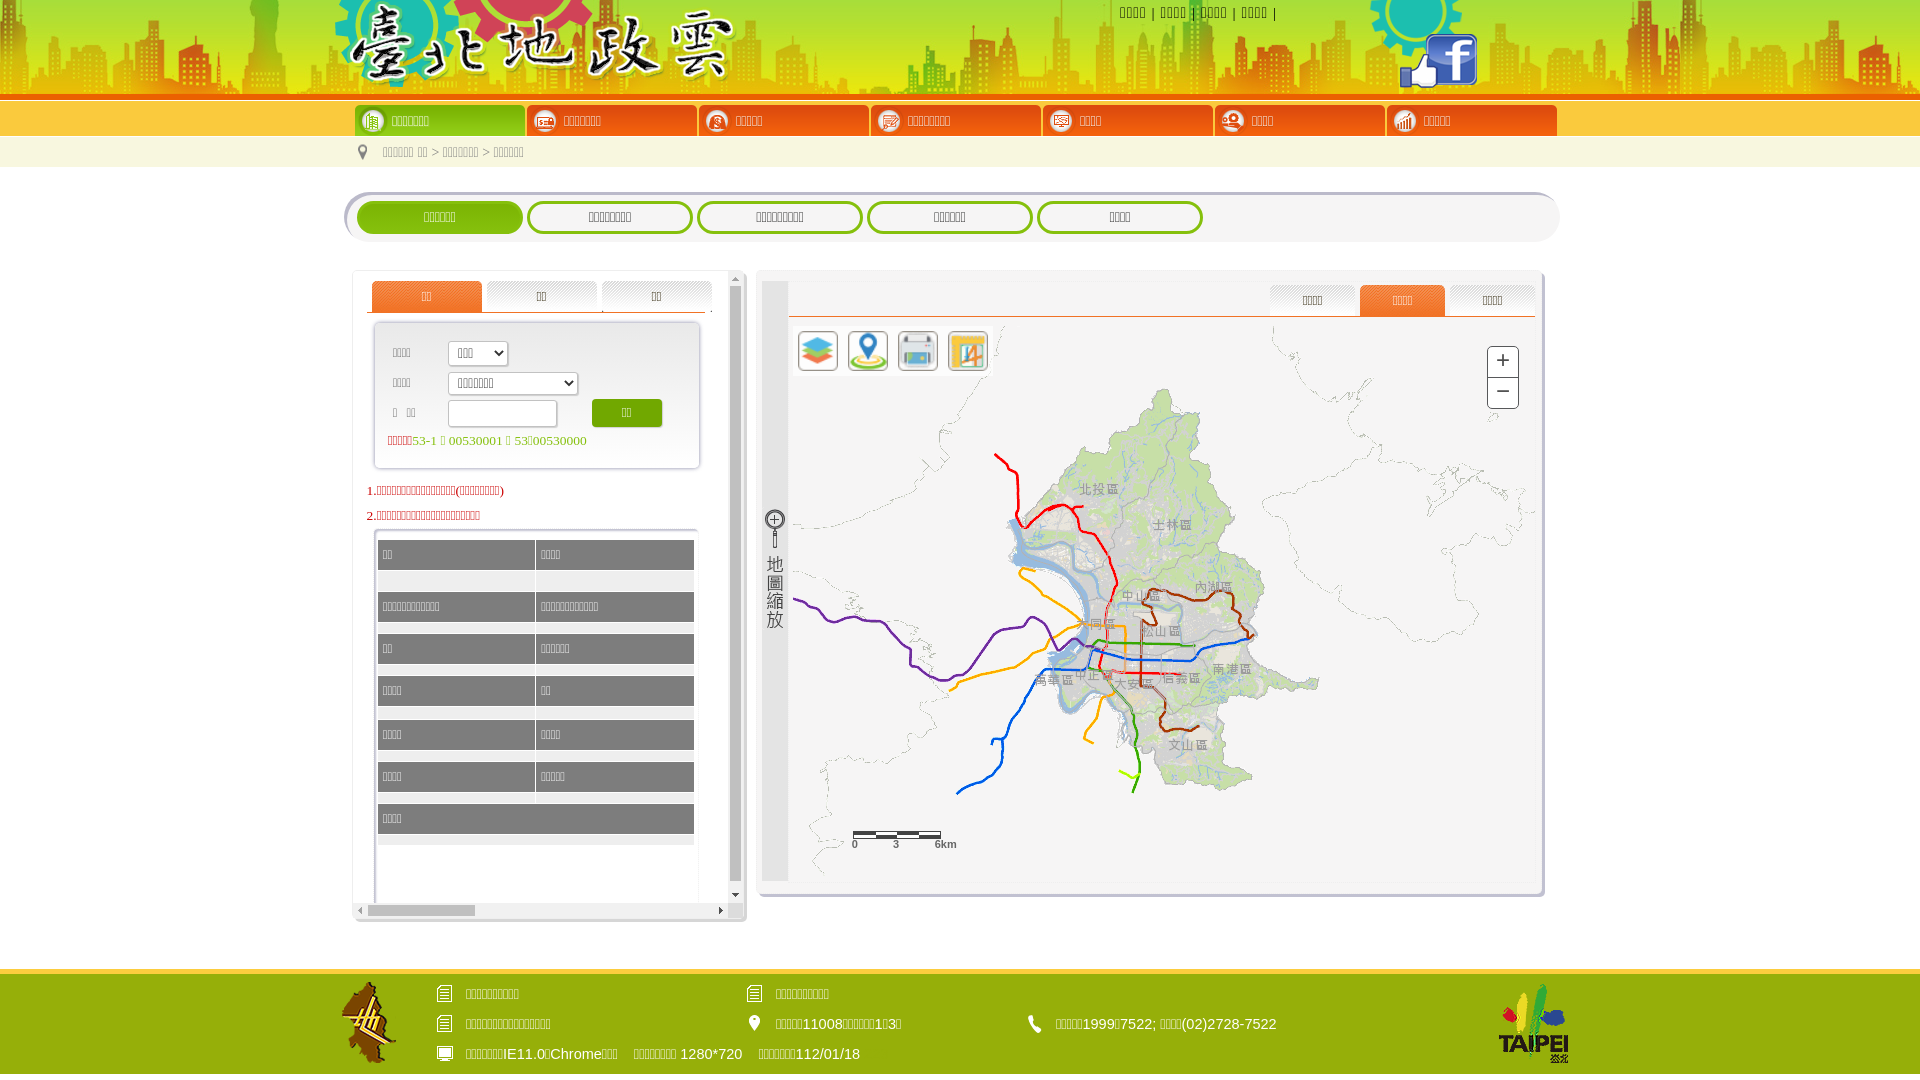

In [8]:
from PIL import Image
driver.save_screenshot('result.png')
img = Image.open('result.png')
img

##### 亦可能出現其他問題
##### 以第四筆資料 (臺北市信義區福德街86號地下) 為例
![](https://imgur.com/aFZvXPI.png)
##### 問題: 停車場未必有辦建物登記，故無法從門牌查到地段號
##### 
##### 若改以地政雲查詢
![](https://imgur.com/hwSvuZ7.png)
##### 可見標的為319地號
##### 但此為人為辨識，無法由程式自動識別